## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create figures directory if it doesn't exist
os.makedirs('../paper/figures', exist_ok=True)

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 150

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the analysis panel
df = pd.read_csv('../data/analysis_panel.csv', parse_dates=['Date'])

# Load industry controls for reference
controls = pd.read_csv('../data/industry_controls_with_sources.csv')

print(f"Analysis Panel Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

Analysis Panel Shape: (31152, 19)

Columns: ['Date', 'Year', 'Month', 'YearMonth', 'Period', 'PeriodName', 'State', 'Industry', 'SeriesID', 'Employment', 'LogEmployment', 'Post', 'HighExposure', 'Treat', 'AI_Exposure_Score', 'Teleworkability', 'RoutineTaskIndex', 'SkillIntensity', 'AutomationRisk_PreAI']


In [5]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31152 entries, 0 to 31151
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  31152 non-null  datetime64[ns]
 1   Year                  31152 non-null  int64         
 2   Month                 31152 non-null  int64         
 3   YearMonth             31152 non-null  int64         
 4   Period                31152 non-null  object        
 5   PeriodName            31152 non-null  object        
 6   State                 31152 non-null  object        
 7   Industry              31152 non-null  object        
 8   SeriesID              31152 non-null  object        
 9   Employment            31152 non-null  float64       
 10  LogEmployment         31152 non-null  float64       
 11  Post                  31152 non-null  int64         
 12  HighExposure          31152 non-null  int64         
 13  Treat           

In [6]:
# First few rows
df.head(10)

,Date,Year,Month,YearMonth,Period,PeriodName,State,Industry,SeriesID,Employment,LogEmployment,Post,HighExposure,Treat,AI_Exposure_Score,Teleworkability,RoutineTaskIndex,SkillIntensity,AutomationRisk_PreAI
0,2015-01-01,2015,1,201501,M01,January,Alabama,Finance and Insurance,SMS01000005552000001,72.6,4.284965,0,1,0,0.5,0.76,0.55,0.52,0.43
1,2015-02-01,2015,2,201502,M02,February,Alabama,Finance and Insurance,SMS01000005552000001,72.6,4.284965,0,1,0,0.5,0.76,0.55,0.52,0.43
2,2015-03-01,2015,3,201503,M03,March,Alabama,Finance and Insurance,SMS01000005552000001,72.8,4.287716,0,1,0,0.5,0.76,0.55,0.52,0.43
3,2015-04-01,2015,4,201504,M04,April,Alabama,Finance and Insurance,SMS01000005552000001,73.1,4.291828,0,1,0,0.5,0.76,0.55,0.52,0.43
4,2015-05-01,2015,5,201505,M05,May,Alabama,Finance and Insurance,SMS01000005552000001,73.2,4.293195,0,1,0,0.5,0.76,0.55,0.52,0.43
5,2015-06-01,2015,6,201506,M06,June,Alabama,Finance and Insurance,SMS01000005552000001,73.2,4.293195,0,1,0,0.5,0.76,0.55,0.52,0.43
6,2015-07-01,2015,7,201507,M07,July,Alabama,Finance and Insurance,SMS01000005552000001,73.3,4.294561,0,1,0,0.5,0.76,0.55,0.52,0.43
7,2015-08-01,2015,8,201508,M08,August,Alabama,Finance and Insurance,SMS01000005552000001,73.2,4.293195,0,1,0,0.5,0.76,0.55,0.52,0.43
8,2015-09-01,2015,9,201509,M09,September,Alabama,Finance and Insurance,SMS01000005552000001,73.0,4.290459,0,1,0,0.5,0.76,0.55,0.52,0.43
9,2015-10-01,2015,10,201510,M10,October,Alabama,Finance and Insurance,SMS01000005552000001,72.5,4.283587,0,1,0,0.5,0.76,0.55,0.52,0.43


## 2. Summary Statistics

In [7]:
# Overall summary statistics
df.describe()

,Date,Year,Month,YearMonth,Employment,LogEmployment,Post,HighExposure,Treat,AI_Exposure_Score,Teleworkability,RoutineTaskIndex,SkillIntensity,AutomationRisk_PreAI
count,31152,31152.000000,31152.000000,31152.000000,31152.000000,31152.000000,31152.000000,31152.000000,31152.000000,31152.00000,31152.000000,31152.000000,31152.000000,31152.000000
mean,2020-02-04 08:45:45.762711808,2019.639831,6.461864,201970.444915,1423.964975,5.094974,0.220339,0.593894,0.134727,0.43135,0.510334,0.417907,0.462275,0.415579
min,2015-01-01 00:00:00,2015.000000,1.000000,201501.000000,2.900000,1.064711,0.000000,0.000000,0.000000,0.28000,0.040000,0.250000,0.120000,0.180000
25%,2017-07-01 00:00:00,2017.000000,3.000000,201707.000000,43.400000,3.770459,0.000000,0.000000,0.000000,0.38000,0.370000,0.350000,0.380000,0.250000
50%,2020-02-01 00:00:00,2020.000000,6.000000,202002.000000,135.700000,4.910447,0.000000,1.000000,0.000000,0.48000,0.680000,0.450000,0.520000,0.430000
75%,2022-09-01 00:00:00,2022.000000,9.000000,202209.000000,499.300000,6.213207,0.000000,1.000000,0.000000,0.50000,0.720000,0.500000,0.580000,0.470000
max,2025-09-01 00:00:00,2025.000000,12.000000,202509.000000,158942.000000,11.976295,1.000000,1.000000,1.000000,0.52000,0.760000,0.550000,0.720000,0.750000
std,NaN,2.964802,3.440831,296.431226,9416.140097,1.879648,0.414482,0.491113,0.341437,0.09060,0.274705,0.106173,0.204306,0.200256


In [8]:
# Summary by treatment status
print("=" * 60)
print("TREATMENT DISTRIBUTION")
print("=" * 60)
print(f"\nTotal Observations: {len(df):,}")
print(f"Unique States: {df['State'].nunique()}")
print(f"Unique Industries: {df['Industry'].nunique()}")
print(f"Time Period: {df['Date'].min()} to {df['Date'].max()}")
print(f"\nPre-period (Post=0): {(df['Post'] == 0).sum():,}")
print(f"Post-period (Post=1): {(df['Post'] == 1).sum():,}")
print(f"\nHigh Exposure (HighExposure=1): {(df['HighExposure'] == 1).sum():,}")
print(f"Low Exposure (HighExposure=0): {(df['HighExposure'] == 0).sum():,}")
print(f"\nTreated (Treat=1): {(df['Treat'] == 1).sum():,}")

TREATMENT DISTRIBUTION

Total Observations: 31,152
Unique States: 52
Unique Industries: 5
Time Period: 2015-01-01 00:00:00 to 2025-09-01 00:00:00

Pre-period (Post=0): 24,288
Post-period (Post=1): 6,864

High Exposure (HighExposure=1): 18,501
Low Exposure (HighExposure=0): 12,651

Treated (Treat=1): 4,197


In [9]:
# Industry-level summary
print("\n" + "=" * 60)
print("INDUSTRY SUMMARY")
print("=" * 60)

industry_summary = df.groupby('Industry').agg({
    'Employment': ['mean', 'std', 'min', 'max'],
    'AI_Exposure_Score': 'first',
    'HighExposure': 'first',
    'Teleworkability': 'first'
}).round(2)

industry_summary.columns = ['Emp_Mean', 'Emp_Std', 'Emp_Min', 'Emp_Max', 
                            'AI_Score', 'HighExposure', 'Telework']
industry_summary = industry_summary.sort_values('AI_Score', ascending=False)
industry_summary


INDUSTRY SUMMARY


,Emp_Mean,Emp_Std,Emp_Min,Emp_Max,AI_Score,HighExposure,Telework
Industry,,,,,,,
Information,110.63,396.48,2.9,3105.0,0.52,1,0.72
Finance and Insurance,265.26,915.16,5.9,6731.4,0.50,1,0.76
"Professional, Scientific, and Technical Services",384.38,1346.01,8.8,10864.8,0.48,1,0.68
Total Nonfarm,5694.36,20169.58,248.9,158942.0,0.38,0,0.37
Leisure and Hospitality,595.69,2127.03,14.5,16979.0,0.28,0,0.04


In [10]:
# Display industry controls
print("\nIndustry Control Variables:")
controls[['Industry', 'AI_Exposure_Score', 'HighExposure', 'Teleworkability', 
          'RoutineTaskIndex', 'SkillIntensity', 'AutomationRisk_PreAI']]


Industry Control Variables:


,Industry,AI_Exposure_Score,HighExposure,Teleworkability,RoutineTaskIndex,SkillIntensity,AutomationRisk_PreAI
0,Information,0.52,1,0.72,0.35,0.58,0.25
1,"Professional, Scientific, and Technical Services",0.48,1,0.68,0.25,0.72,0.18
2,Finance and Insurance,0.50,1,0.76,0.55,0.52,0.43
3,Leisure and Hospitality,0.28,0,0.04,0.45,0.12,0.75
4,Total Nonfarm,0.38,0,0.37,0.50,0.38,0.47


## 3. Employment Trends Over Time

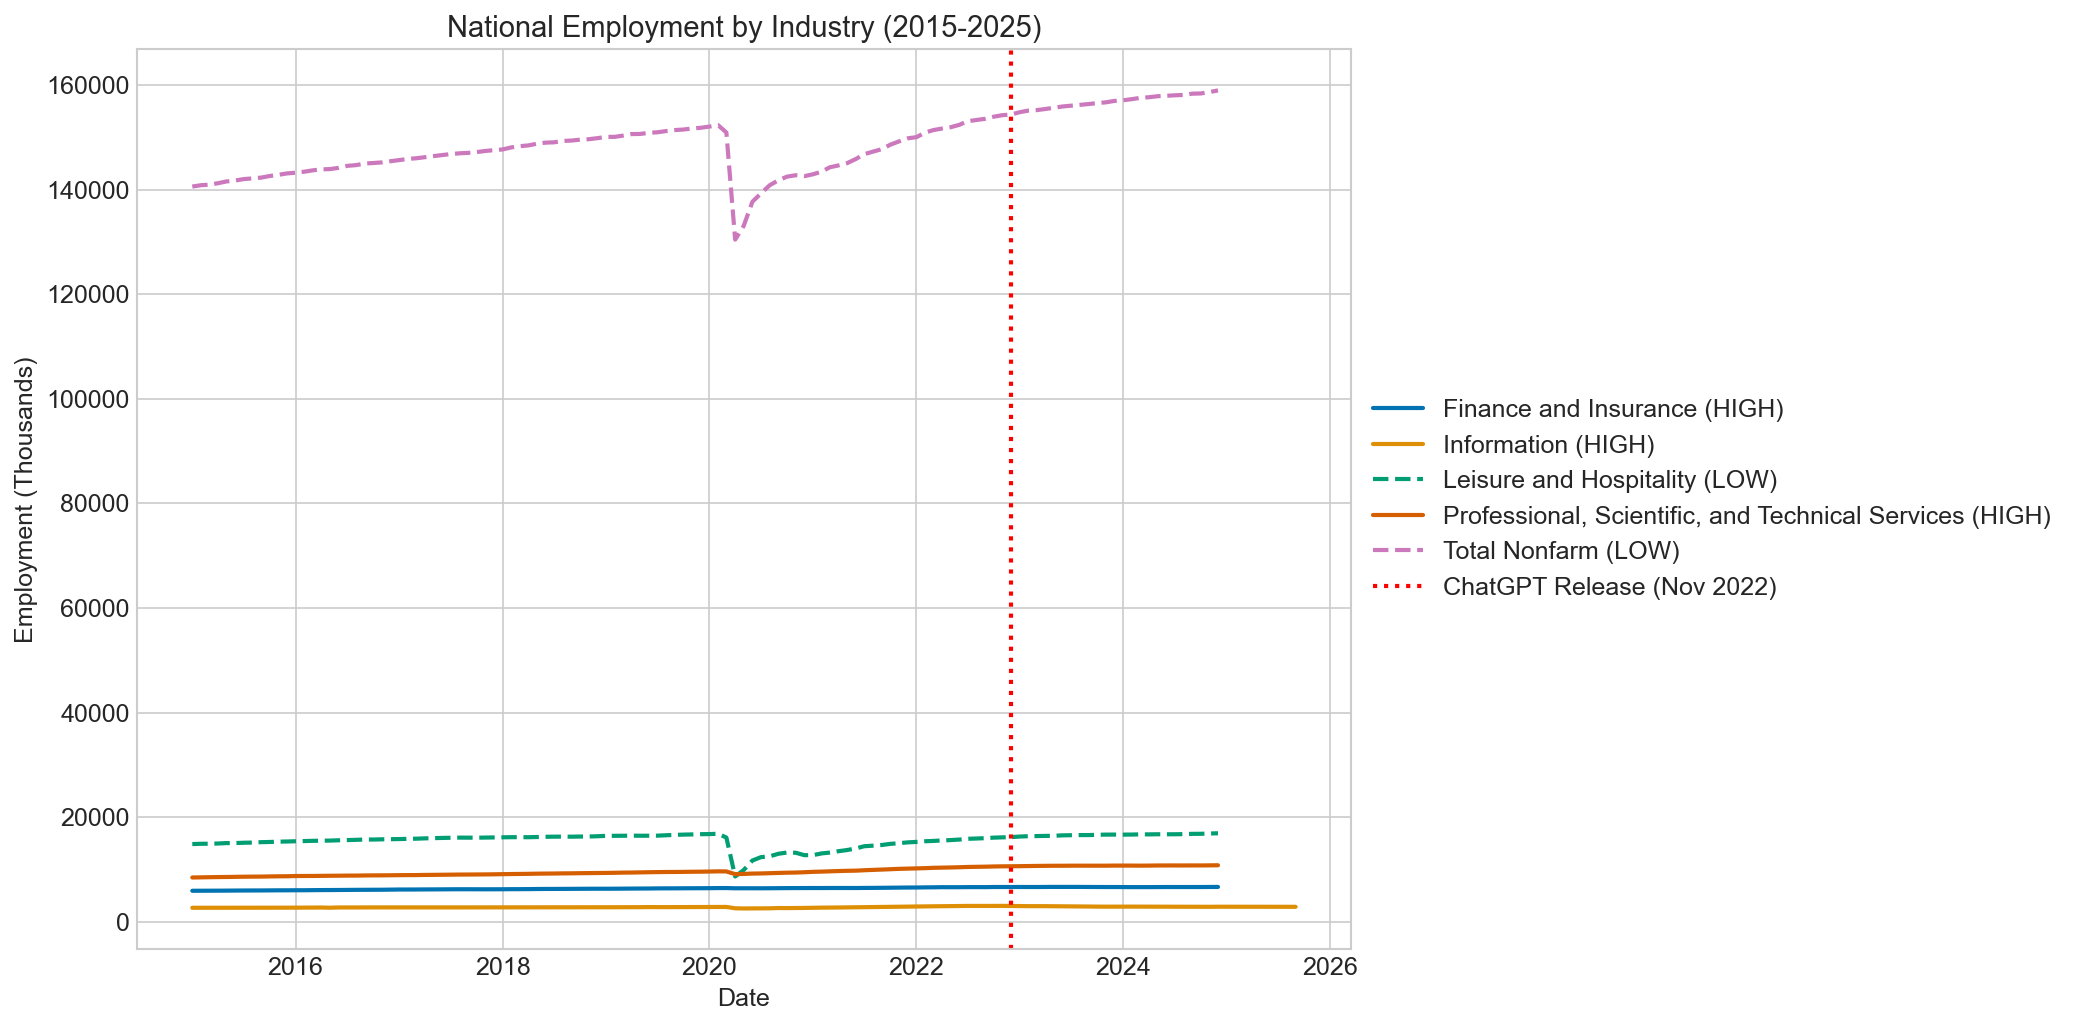

Saved: employment_trends_raw.pdf


In [3]:
# National-level employment trends by industry
national = df[df['State'] == 'Total'].copy()
baseline_date = pd.Timestamp('2015-01-01')

fig, ax = plt.subplots(figsize=(14, 7))

for industry in national['Industry'].unique():
    ind_data = national[national['Industry'] == industry]
    high_exp = ind_data['HighExposure'].iloc[0]
    linestyle = '-' if high_exp == 1 else '--'
    ax.plot(ind_data['Date'], ind_data['Employment'], 
            label=f"{industry} ({'HIGH' if high_exp else 'LOW'})",
            linestyle=linestyle, linewidth=2)

# Add vertical line for ChatGPT release
ax.axvline(pd.Timestamp('2022-11-30'), color='red', linestyle=':', linewidth=2, 
           label='ChatGPT Release (Nov 2022)')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Employment (Thousands)', fontsize=12)
ax.set_title('National Employment by Industry (2015-2025)', fontsize=14)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('../paper/figures/employment_trends_raw.pdf', bbox_inches='tight', dpi=300)
plt.savefig('../paper/figures/employment_trends_raw.png', bbox_inches='tight', dpi=300)
plt.show()
print("Saved: employment_trends_raw.pdf")

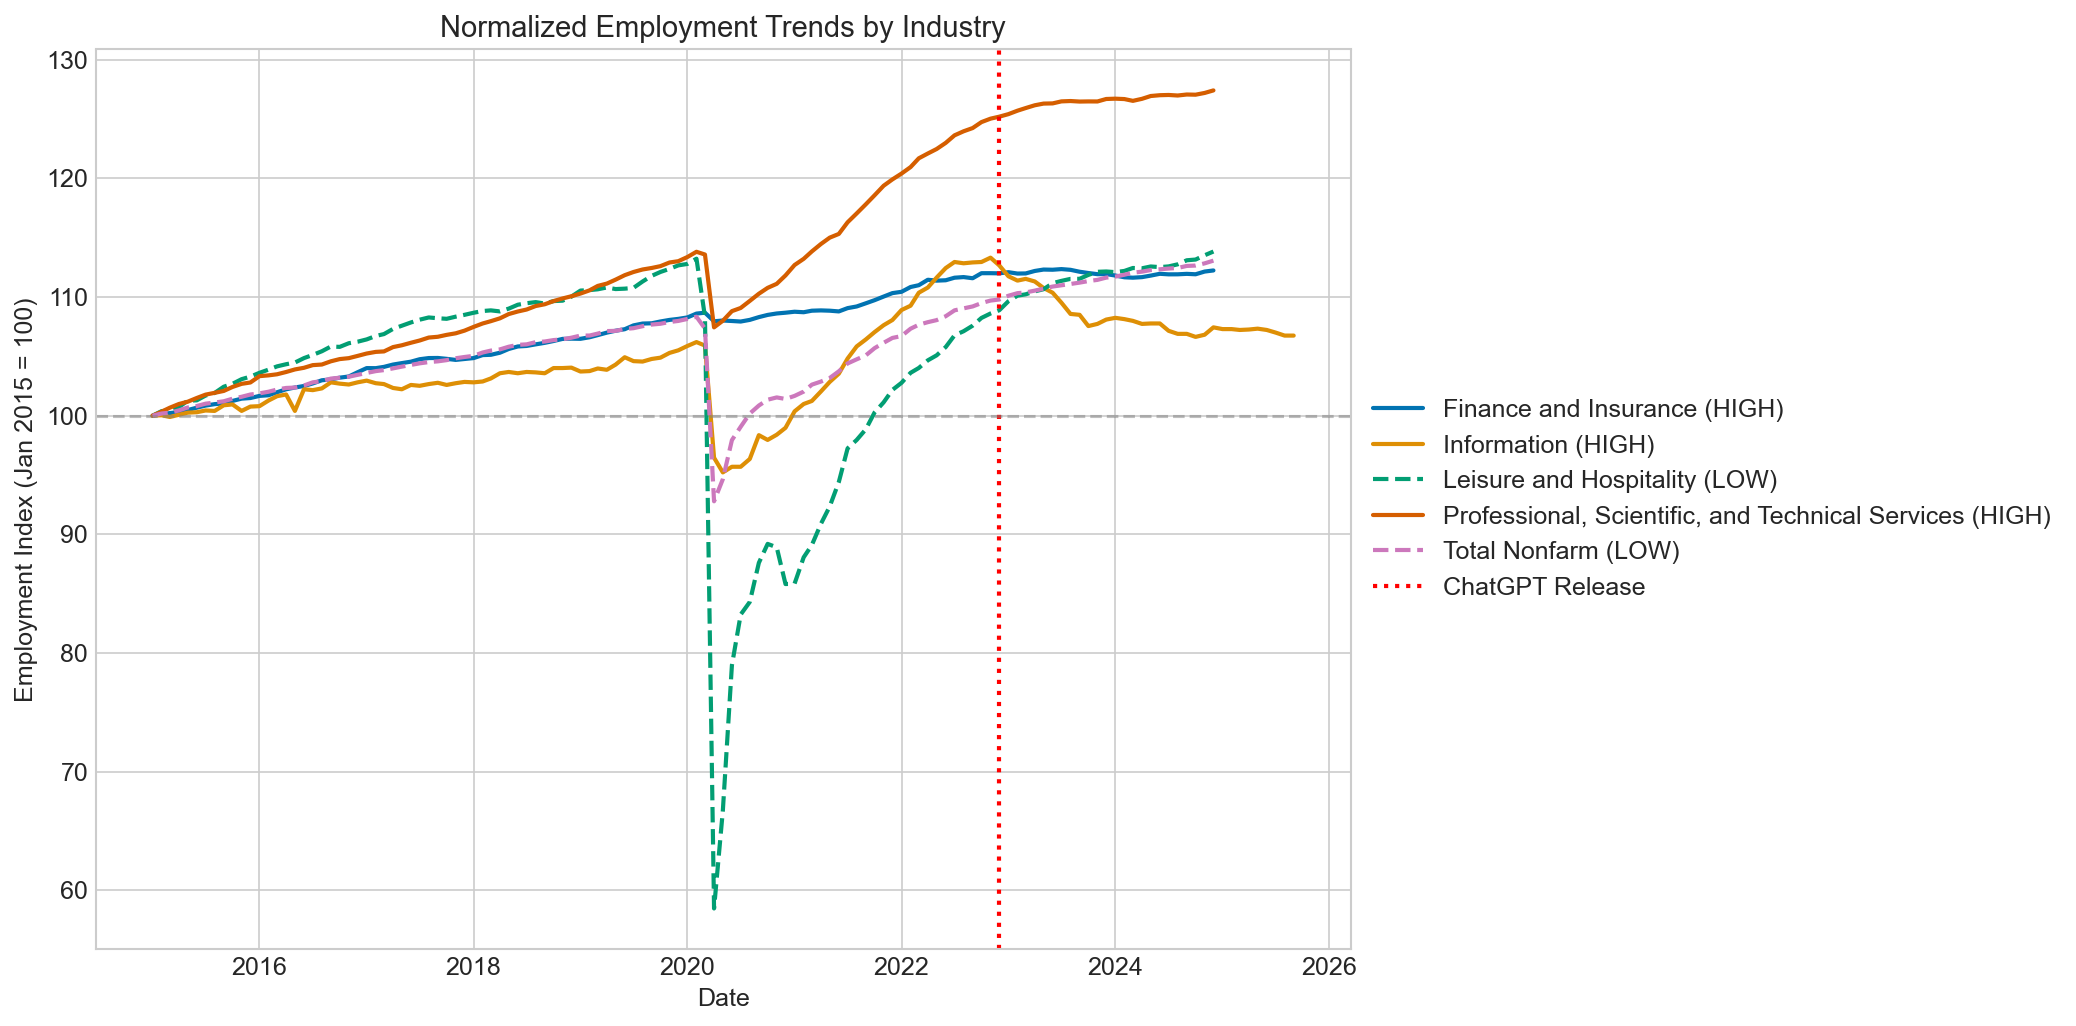

Saved: employment_trends_normalized.pdf


In [4]:
# Normalized employment trends (index to 100 at baseline)
fig, ax = plt.subplots(figsize=(14, 7))

for industry in national['Industry'].unique():
    ind_data = national[national['Industry'] == industry].copy()
    baseline_emp = ind_data[ind_data['Date'] == baseline_date]['Employment'].values[0]
    ind_data['Normalized'] = (ind_data['Employment'] / baseline_emp) * 100
    
    high_exp = ind_data['HighExposure'].iloc[0]
    linestyle = '-' if high_exp == 1 else '--'
    ax.plot(ind_data['Date'], ind_data['Normalized'], 
            label=f"{industry} ({'HIGH' if high_exp else 'LOW'})",
            linestyle=linestyle, linewidth=2)

ax.axvline(pd.Timestamp('2022-11-30'), color='red', linestyle=':', linewidth=2, 
           label='ChatGPT Release')
ax.axhline(100, color='gray', linestyle='--', alpha=0.5)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Employment Index (Jan 2015 = 100)', fontsize=12)
ax.set_title('Normalized Employment Trends by Industry', fontsize=14)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('../paper/figures/employment_trends_normalized.pdf', bbox_inches='tight', dpi=300)
plt.savefig('../paper/figures/employment_trends_normalized.png', bbox_inches='tight', dpi=300)
plt.show()
print("Saved: employment_trends_normalized.pdf")

## 4. Pre-Treatment Parallel Trends Check

A key assumption of DiD is that treatment and control groups would have followed parallel trends in the absence of treatment.

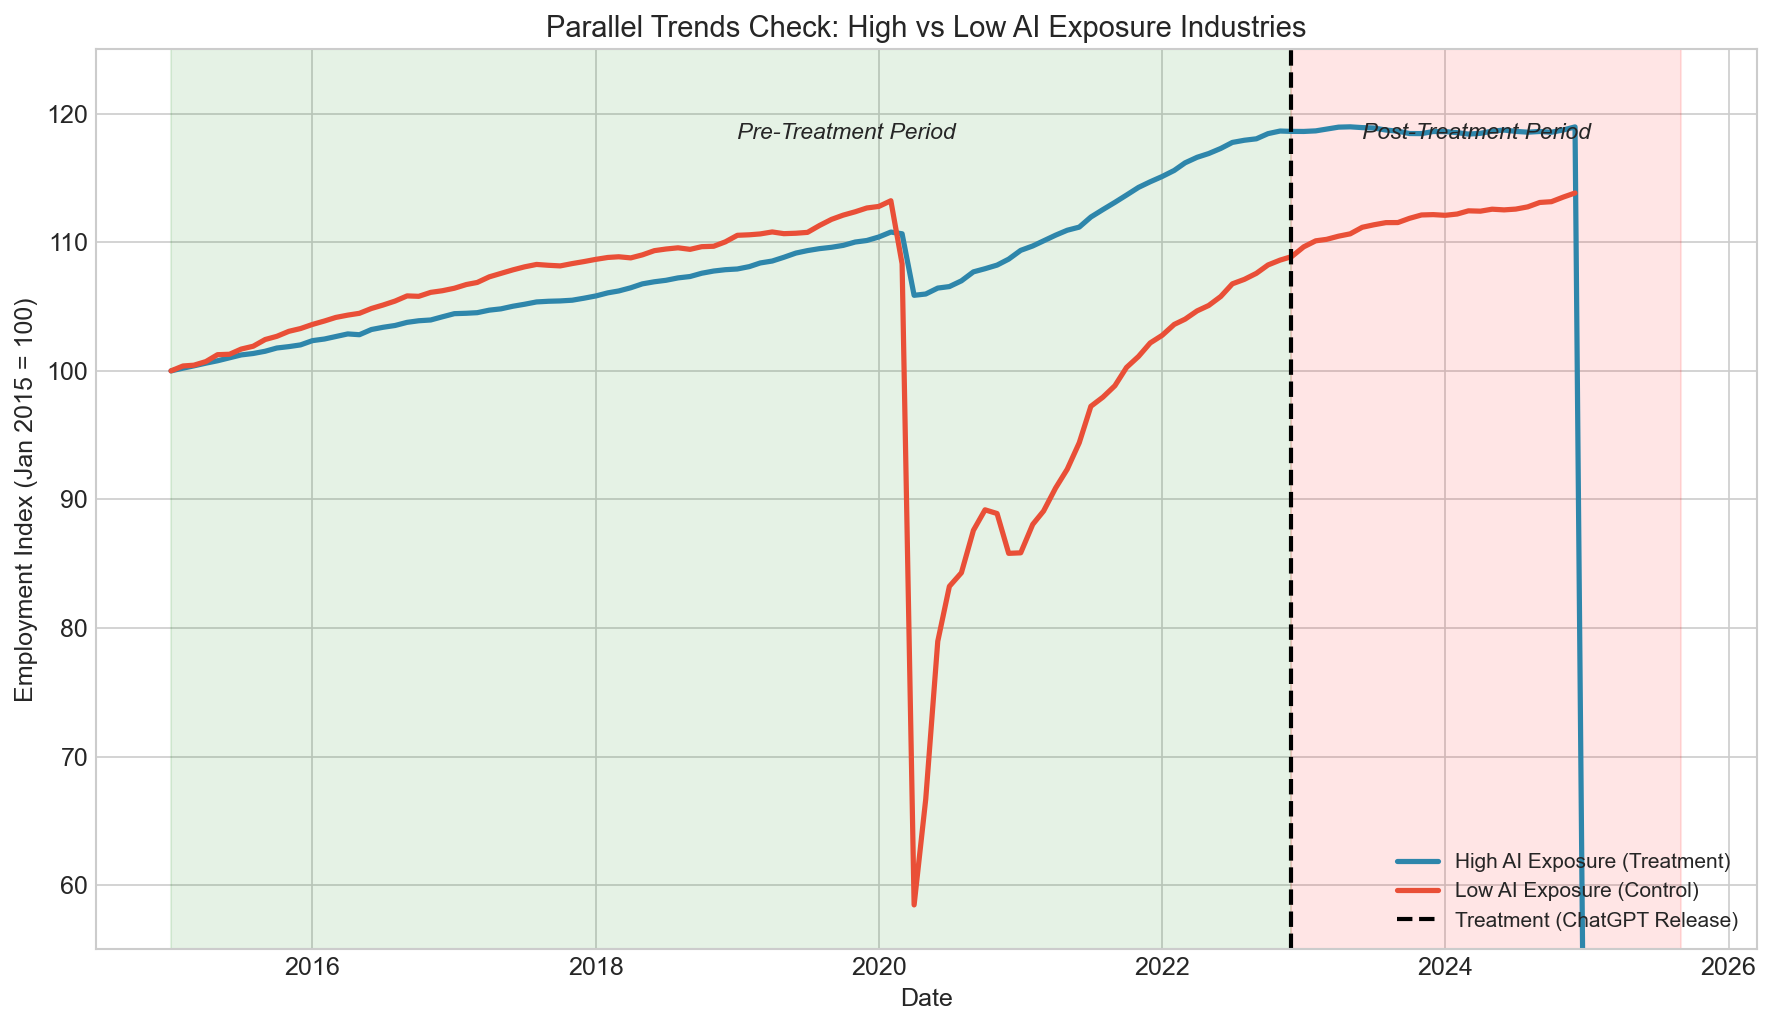

Saved: parallel_trends.pdf


In [5]:
# Parallel Trends: High vs Low AI Exposure Groups
# Exclude Total Nonfarm for cleaner comparison
national_excl_total = national[national['Industry'] != 'Total Nonfarm'].copy()

# Calculate average employment by exposure group and date
group_trends = national_excl_total.groupby(['Date', 'HighExposure'])['Employment'].sum().reset_index()

# Normalize to baseline
baseline_high = group_trends[(group_trends['Date'] == baseline_date) & (group_trends['HighExposure'] == 1)]['Employment'].values[0]
baseline_low = group_trends[(group_trends['Date'] == baseline_date) & (group_trends['HighExposure'] == 0)]['Employment'].values[0]

group_trends['Normalized'] = group_trends.apply(
    lambda x: (x['Employment'] / baseline_high * 100) if x['HighExposure'] == 1 
              else (x['Employment'] / baseline_low * 100), axis=1
)

fig, ax = plt.subplots(figsize=(12, 7))

for exp in [1, 0]:
    data = group_trends[group_trends['HighExposure'] == exp]
    label = 'High AI Exposure (Treatment)' if exp == 1 else 'Low AI Exposure (Control)'
    color = '#2E86AB' if exp == 1 else '#E94F37'
    ax.plot(data['Date'], data['Normalized'], label=label, linewidth=2.5, color=color)

# Mark pre and post periods
ax.axvline(pd.Timestamp('2022-11-30'), color='black', linestyle='--', linewidth=2, 
           label='Treatment (ChatGPT Release)')
ax.axvspan(df['Date'].min(), pd.Timestamp('2022-11-30'), alpha=0.1, color='green')
ax.axvspan(pd.Timestamp('2022-11-30'), df['Date'].max(), alpha=0.1, color='red')

# Add text annotations
ax.text(pd.Timestamp('2019-01-01'), 118, 'Pre-Treatment Period', fontsize=11, style='italic')
ax.text(pd.Timestamp('2023-06-01'), 118, 'Post-Treatment Period', fontsize=11, style='italic')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Employment Index (Jan 2015 = 100)', fontsize=12)
ax.set_title('Parallel Trends Check: High vs Low AI Exposure Industries', fontsize=14)
ax.legend(loc='lower right', fontsize=10)
ax.set_ylim([55, 125])
plt.tight_layout()
plt.savefig('../paper/figures/parallel_trends.pdf', bbox_inches='tight', dpi=300)
plt.savefig('../paper/figures/parallel_trends.png', bbox_inches='tight', dpi=300)
plt.show()
print("Saved: parallel_trends.pdf")

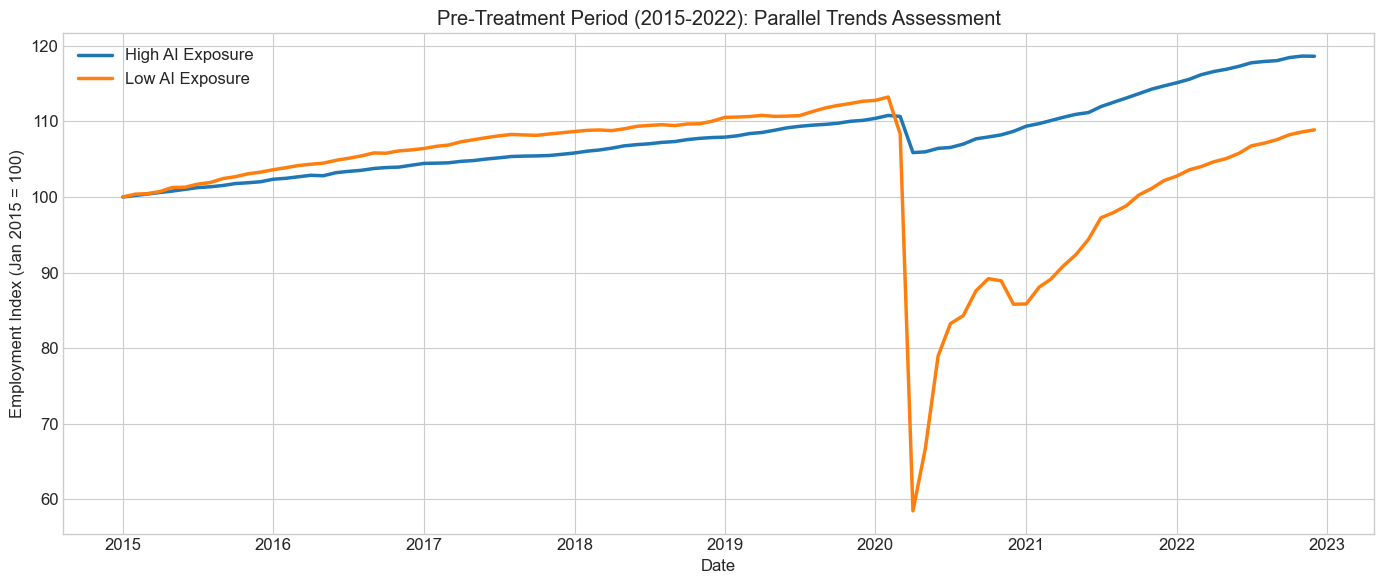

Note: COVID-19 shock in 2020 affects both groups. Consider robustness checks excluding 2020.


In [14]:
# Zoom in on pre-period for parallel trends
pre_period = group_trends[group_trends['Date'] < pd.Timestamp('2023-01-01')]

fig, ax = plt.subplots(figsize=(14, 6))

for exp in [1, 0]:
    data = pre_period[pre_period['HighExposure'] == exp]
    label = 'High AI Exposure' if exp == 1 else 'Low AI Exposure'
    color = 'tab:blue' if exp == 1 else 'tab:orange'
    ax.plot(data['Date'], data['Normalized'], label=label, linewidth=2.5, color=color)

ax.set_xlabel('Date')
ax.set_ylabel('Employment Index (Jan 2015 = 100)')
ax.set_title('Pre-Treatment Period (2015-2022): Parallel Trends Assessment')
ax.legend()
plt.tight_layout()
plt.show()

print("Note: COVID-19 shock in 2020 affects both groups. Consider robustness checks excluding 2020.")

## 5. Difference-in-Differences Visual

In [15]:
# Calculate group means for DiD
did_summary = national_excl_total.groupby(['Post', 'HighExposure']).agg({
    'Employment': 'sum'
}).reset_index()

# Normalize
base_high = did_summary[(did_summary['Post'] == 0) & (did_summary['HighExposure'] == 1)]['Employment'].values[0]
base_low = did_summary[(did_summary['Post'] == 0) & (did_summary['HighExposure'] == 0)]['Employment'].values[0]

did_summary['Normalized'] = did_summary.apply(
    lambda x: (x['Employment'] / base_high * 100) if x['HighExposure'] == 1 
              else (x['Employment'] / base_low * 100), axis=1
)

print("DiD Summary (Normalized to Pre-Period = 100):")
print(did_summary.pivot(index='HighExposure', columns='Post', values='Normalized'))

# Calculate DiD estimate
high_pre = did_summary[(did_summary['Post'] == 0) & (did_summary['HighExposure'] == 1)]['Normalized'].values[0]
high_post = did_summary[(did_summary['Post'] == 1) & (did_summary['HighExposure'] == 1)]['Normalized'].values[0]
low_pre = did_summary[(did_summary['Post'] == 0) & (did_summary['HighExposure'] == 0)]['Normalized'].values[0]
low_post = did_summary[(did_summary['Post'] == 1) & (did_summary['HighExposure'] == 0)]['Normalized'].values[0]

did_estimate = (high_post - high_pre) - (low_post - low_pre)
print(f"\nSimple DiD Estimate (normalized): {did_estimate:.2f}")
print(f"High Exposure Change: {high_post - high_pre:.2f}")
print(f"Low Exposure Change: {low_post - low_pre:.2f}")

DiD Summary (Normalized to Pre-Period = 100):
Post              0          1
HighExposure                  
0             100.0  27.168824
1             100.0  28.996671

Simple DiD Estimate (normalized): 1.83
High Exposure Change: -71.00
Low Exposure Change: -72.83


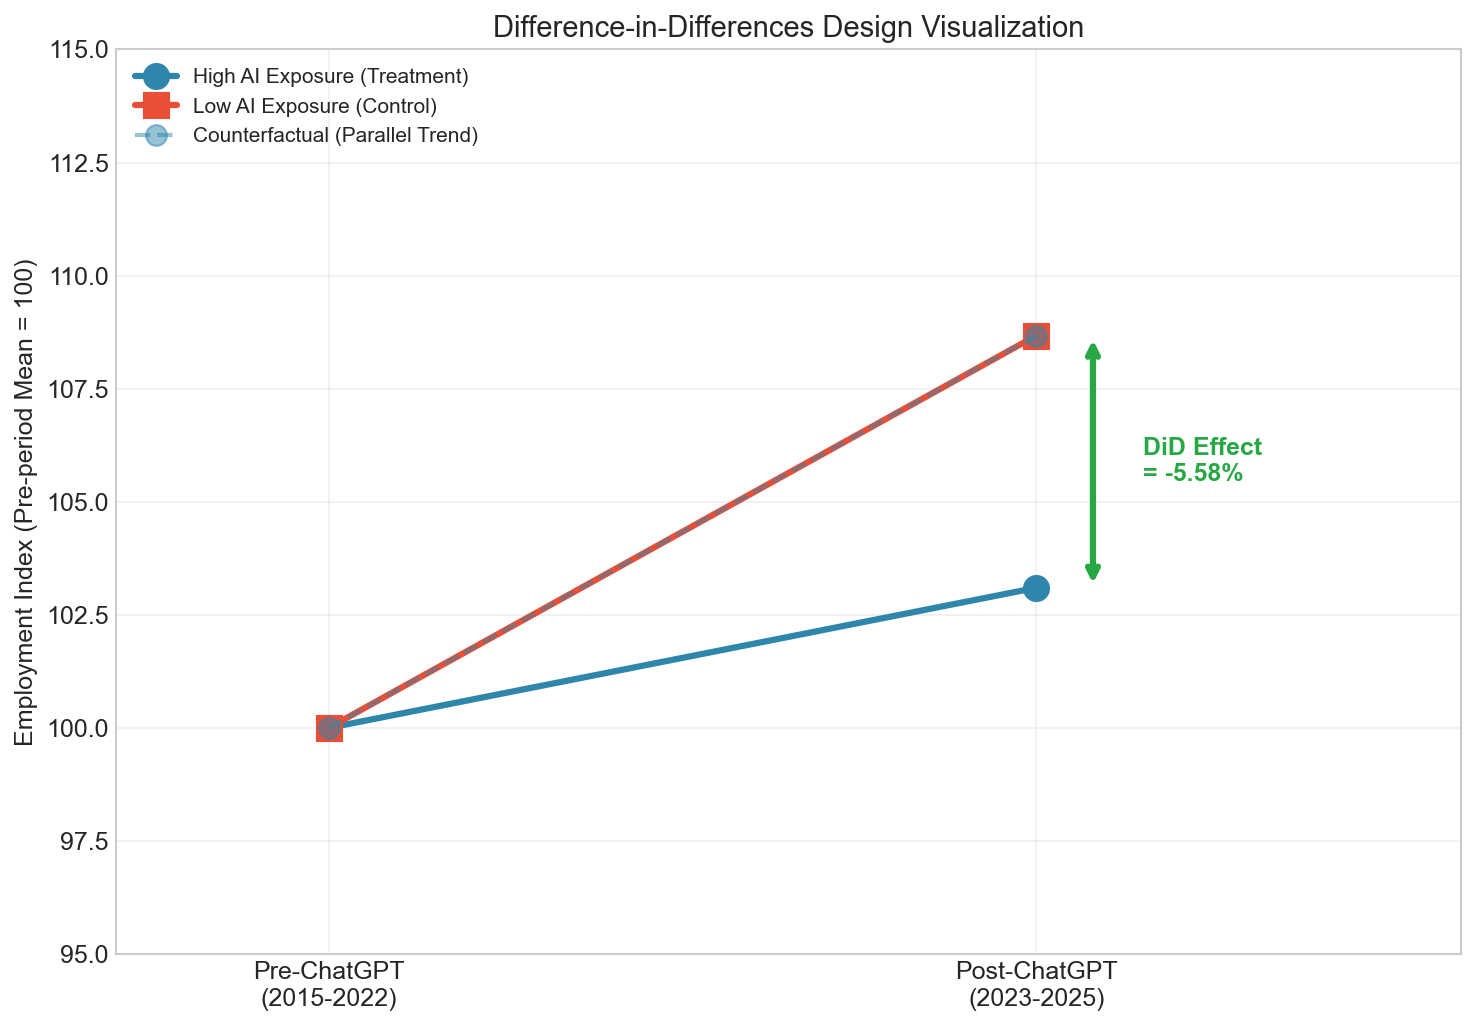


DiD Summary:
High Exposure - Pre: 100.00, Post: 103.10, Change: 3.10%
Low Exposure - Pre: 100.00, Post: 108.68, Change: 8.68%
DiD Estimate: -5.58%

Saved: did_visualization.pdf


In [6]:
# Calculate DiD Summary Statistics
did_summary = national_excl_total.groupby(['Post', 'HighExposure']).agg({
    'Employment': 'mean'  # Use mean across time periods
}).reset_index()

# Get values for DiD calculation
high_pre = did_summary[(did_summary['Post'] == 0) & (did_summary['HighExposure'] == 1)]['Employment'].values[0]
high_post = did_summary[(did_summary['Post'] == 1) & (did_summary['HighExposure'] == 1)]['Employment'].values[0]
low_pre = did_summary[(did_summary['Post'] == 0) & (did_summary['HighExposure'] == 0)]['Employment'].values[0]
low_post = did_summary[(did_summary['Post'] == 1) & (did_summary['HighExposure'] == 0)]['Employment'].values[0]

# Normalize to pre-period = 100
high_pre_norm, high_post_norm = 100, (high_post / high_pre) * 100
low_pre_norm, low_post_norm = 100, (low_post / low_pre) * 100

did_estimate = (high_post_norm - high_pre_norm) - (low_post_norm - low_pre_norm)

# DiD visualization
fig, ax = plt.subplots(figsize=(10, 7))

x = [0, 1]
labels = ['Pre-ChatGPT\n(2015-2022)', 'Post-ChatGPT\n(2023-2025)']

# Actual trends
ax.plot(x, [high_pre_norm, high_post_norm], 'o-', linewidth=3, markersize=12, 
        color='#2E86AB', label='High AI Exposure (Treatment)')
ax.plot(x, [low_pre_norm, low_post_norm], 's-', linewidth=3, markersize=12, 
        color='#E94F37', label='Low AI Exposure (Control)')

# Counterfactual (parallel trend for treatment group)
counterfactual = high_pre_norm + (low_post_norm - low_pre_norm)
ax.plot(x, [high_pre_norm, counterfactual], 'o--', linewidth=2, markersize=10, 
        color='#2E86AB', alpha=0.5, label='Counterfactual (Parallel Trend)')

# DiD effect annotation
ax.annotate('', xy=(1.08, high_post_norm), xytext=(1.08, counterfactual),
            arrowprops=dict(arrowstyle='<->', color='#28A745', lw=3))
ax.text(1.15, (high_post_norm + counterfactual) / 2, f'DiD Effect\n= {did_estimate:.2f}%', 
        fontsize=12, color='#28A745', va='center', fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.set_ylabel('Employment Index (Pre-period Mean = 100)', fontsize=12)
ax.set_title('Difference-in-Differences Design Visualization', fontsize=14)
ax.legend(loc='upper left', fontsize=10)
ax.set_xlim(-0.3, 1.6)
ax.set_ylim([95, 115])
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../paper/figures/did_visualization.pdf', bbox_inches='tight', dpi=300)
plt.savefig('../paper/figures/did_visualization.png', bbox_inches='tight', dpi=300)
plt.show()

print(f"\nDiD Summary:")
print(f"High Exposure - Pre: {high_pre_norm:.2f}, Post: {high_post_norm:.2f}, Change: {high_post_norm - high_pre_norm:.2f}%")
print(f"Low Exposure - Pre: {low_pre_norm:.2f}, Post: {low_post_norm:.2f}, Change: {low_post_norm - low_pre_norm:.2f}%")
print(f"DiD Estimate: {did_estimate:.2f}%")
print("\nSaved: did_visualization.pdf")

## 6. State-Level Variation

In [17]:
# State-level summary (excluding national total)
states_only = df[df['State'] != 'Total'].copy()

state_summary = states_only.groupby('State').agg({
    'Employment': 'mean'
}).sort_values('Employment', ascending=False)

print("Top 10 States by Average Employment:")
state_summary.head(10)

Top 10 States by Average Employment:


,Employment
State,
California,4206.337438
Texas,3190.186357
New York,2338.671921
Florida,2234.026108
Illinois,1463.678982
Pennsylvania,1417.841051
Ohio,1307.605747
Georgia,1118.635796
North Carolina,1111.701478


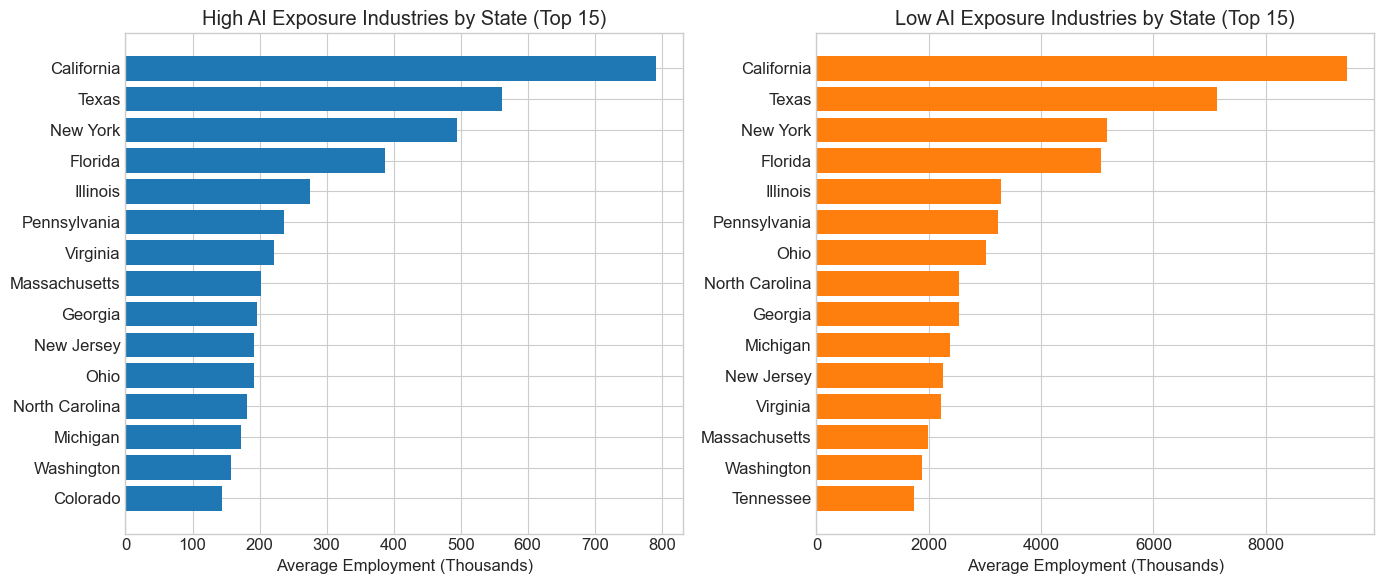

In [18]:
# Employment distribution by state and exposure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# High exposure industries
high_exp = states_only[states_only['HighExposure'] == 1]
state_high = high_exp.groupby('State')['Employment'].mean().sort_values(ascending=False).head(15)
axes[0].barh(state_high.index, state_high.values, color='tab:blue')
axes[0].set_xlabel('Average Employment (Thousands)')
axes[0].set_title('High AI Exposure Industries by State (Top 15)')
axes[0].invert_yaxis()

# Low exposure industries  
low_exp = states_only[states_only['HighExposure'] == 0]
state_low = low_exp.groupby('State')['Employment'].mean().sort_values(ascending=False).head(15)
axes[1].barh(state_low.index, state_low.values, color='tab:orange')
axes[1].set_xlabel('Average Employment (Thousands)')
axes[1].set_title('Low AI Exposure Industries by State (Top 15)')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 7. COVID-19 Impact Assessment

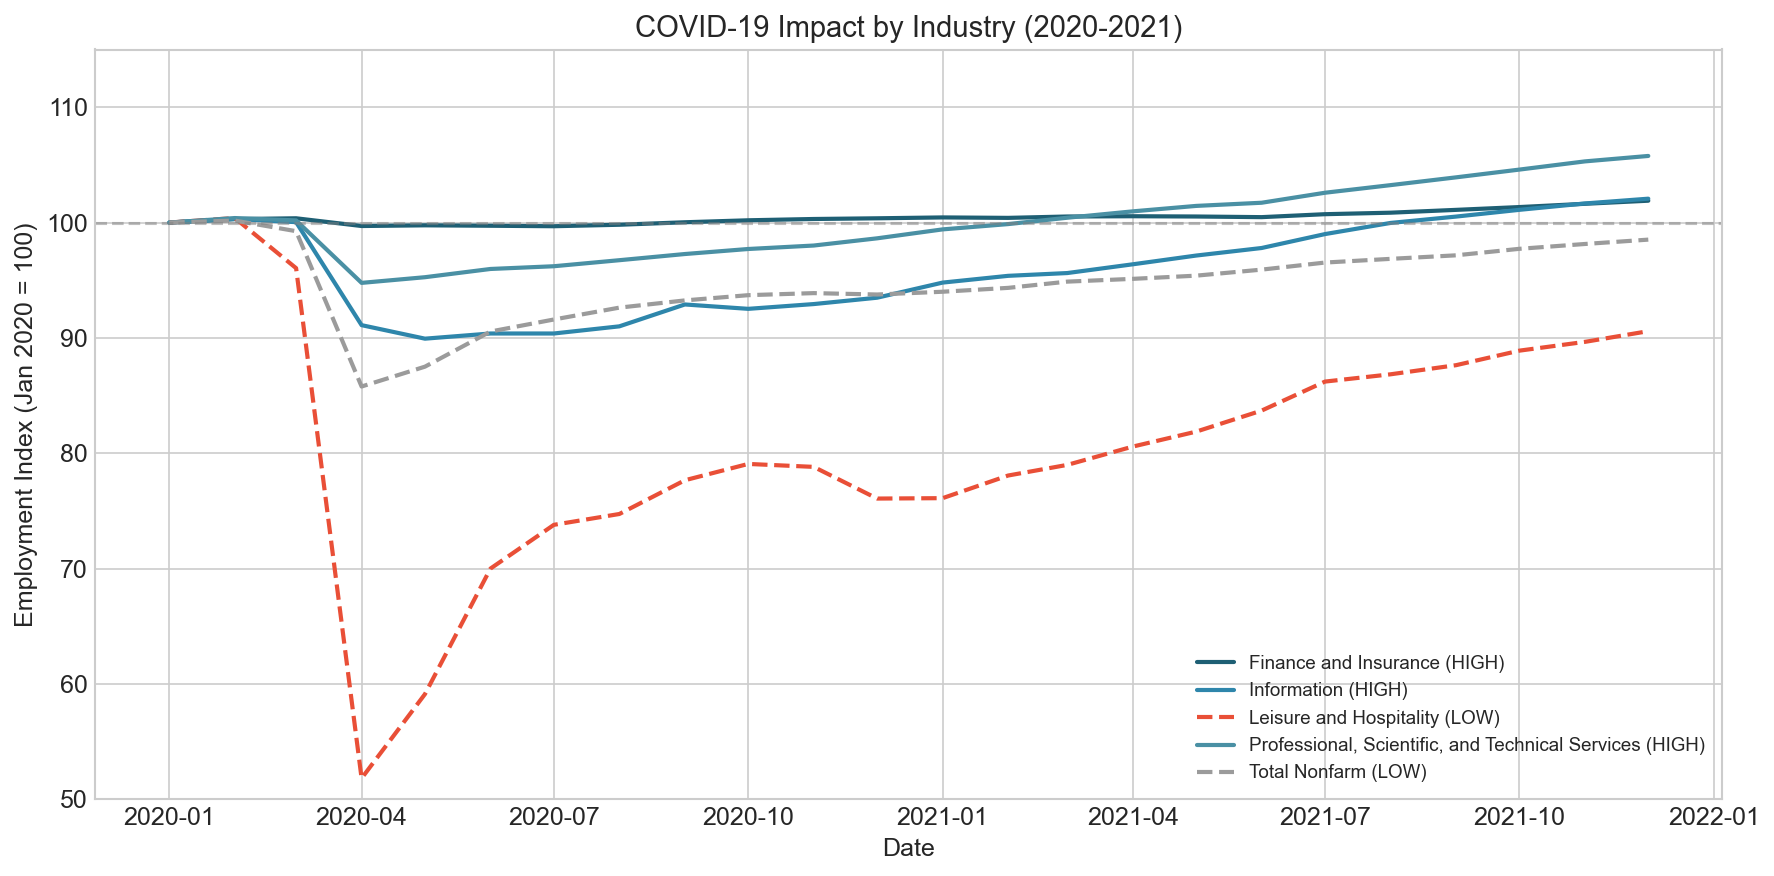


Note: Leisure & Hospitality experienced the most severe COVID impact (-47% at trough).
This differential shock should be considered in robustness checks.

Saved: covid_impact.pdf


In [7]:
# COVID-19 Impact by Industry
covid_period = national[(national['Date'] >= '2020-01-01') & (national['Date'] <= '2021-12-31')]

fig, ax = plt.subplots(figsize=(12, 6))

colors = {'Information': '#2E86AB', 'Finance and Insurance': '#1E5F74', 
          'Professional, Scientific, and Technical Services': '#4A90A4',
          'Leisure and Hospitality': '#E94F37', 'Total Nonfarm': '#9B9B9B'}

for industry in national['Industry'].unique():
    ind_data = covid_period[covid_period['Industry'] == industry]
    baseline = ind_data[ind_data['Date'] == pd.Timestamp('2020-01-01')]['Employment'].values
    if len(baseline) > 0:
        normalized = (ind_data['Employment'] / baseline[0]) * 100
        high_exp = ind_data['HighExposure'].iloc[0]
        linestyle = '-' if high_exp == 1 else '--'
        ax.plot(ind_data['Date'], normalized, 
                label=f"{industry} ({'HIGH' if high_exp else 'LOW'})",
                linestyle=linestyle, linewidth=2, color=colors.get(industry, 'gray'))

ax.axhline(100, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Employment Index (Jan 2020 = 100)', fontsize=12)
ax.set_title('COVID-19 Impact by Industry (2020-2021)', fontsize=14)
ax.legend(loc='lower right', fontsize=9)
ax.set_ylim([50, 115])
plt.tight_layout()
plt.savefig('../paper/figures/covid_impact.pdf', bbox_inches='tight', dpi=300)
plt.savefig('../paper/figures/covid_impact.png', bbox_inches='tight', dpi=300)
plt.show()

print("\nNote: Leisure & Hospitality experienced the most severe COVID impact (-47% at trough).")
print("This differential shock should be considered in robustness checks.")
print("\nSaved: covid_impact.pdf")

## 8. Correlation Analysis

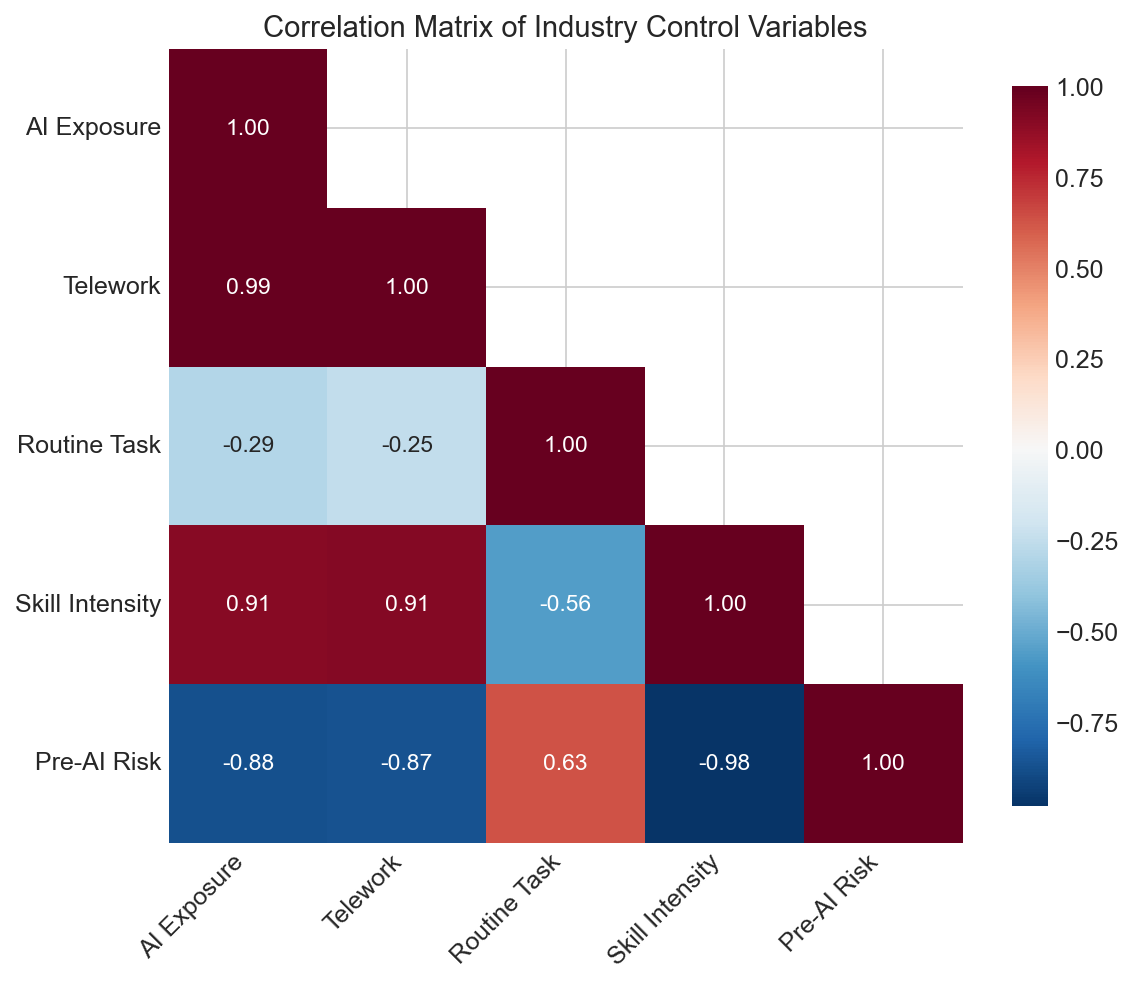

Note: High correlations between controls are expected since they capture related industry characteristics.
These will be absorbed by industry fixed effects in the regression.

Saved: correlation_matrix.pdf


In [8]:
# Correlation matrix for control variables
control_vars = ['AI_Exposure_Score', 'Teleworkability', 'RoutineTaskIndex', 
                'SkillIntensity', 'AutomationRisk_PreAI']

# Get unique industry-level values
industry_controls = df.groupby('Industry')[control_vars].first()

fig, ax = plt.subplots(figsize=(8, 7))
corr_matrix = industry_controls.corr()

# Create a mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, ax=ax, fmt='.2f', mask=mask,
            cbar_kws={'shrink': 0.8},
            annot_kws={'fontsize': 11})
ax.set_title('Correlation Matrix of Industry Control Variables', fontsize=14)

# Improve label readability
labels = ['AI Exposure', 'Telework', 'Routine Task', 'Skill Intensity', 'Pre-AI Risk']
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels, rotation=0)

plt.tight_layout()
plt.savefig('../paper/figures/correlation_matrix.pdf', bbox_inches='tight', dpi=300)
plt.savefig('../paper/figures/correlation_matrix.png', bbox_inches='tight', dpi=300)
plt.show()

print("Note: High correlations between controls are expected since they capture related industry characteristics.")
print("These will be absorbed by industry fixed effects in the regression.")
print("\nSaved: correlation_matrix.pdf")

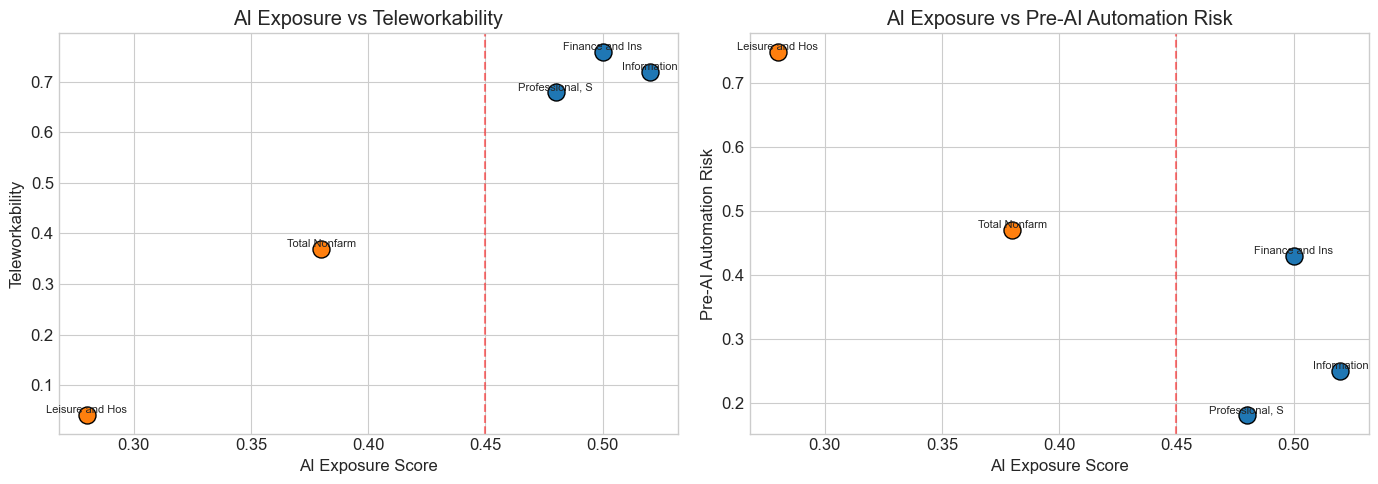


Key Insight: High AI exposure industries tend to be highly teleworkable
but had LOW pre-AI automation risk (non-routine cognitive work).


In [21]:
# Scatter plot: AI Exposure vs Teleworkability
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# AI Exposure vs Teleworkability
for _, row in industry_controls.iterrows():
    color = 'tab:blue' if row['AI_Exposure_Score'] >= 0.45 else 'tab:orange'
    axes[0].scatter(row['AI_Exposure_Score'], row['Teleworkability'], 
                   s=150, c=color, edgecolors='black')
    axes[0].annotate(row.name[:15], (row['AI_Exposure_Score'], row['Teleworkability']),
                    fontsize=8, ha='center', va='bottom')

axes[0].set_xlabel('AI Exposure Score')
axes[0].set_ylabel('Teleworkability')
axes[0].set_title('AI Exposure vs Teleworkability')
axes[0].axvline(0.45, color='red', linestyle='--', alpha=0.5, label='High Exposure Threshold')

# AI Exposure vs Pre-AI Automation Risk
for _, row in industry_controls.iterrows():
    color = 'tab:blue' if row['AI_Exposure_Score'] >= 0.45 else 'tab:orange'
    axes[1].scatter(row['AI_Exposure_Score'], row['AutomationRisk_PreAI'], 
                   s=150, c=color, edgecolors='black')
    axes[1].annotate(row.name[:15], (row['AI_Exposure_Score'], row['AutomationRisk_PreAI']),
                    fontsize=8, ha='center', va='bottom')

axes[1].set_xlabel('AI Exposure Score')
axes[1].set_ylabel('Pre-AI Automation Risk')
axes[1].set_title('AI Exposure vs Pre-AI Automation Risk')
axes[1].axvline(0.45, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\nKey Insight: High AI exposure industries tend to be highly teleworkable")
print("but had LOW pre-AI automation risk (non-routine cognitive work).")

## 9. Data Quality Checks

In [22]:
# Missing values
print("Missing Values by Column:")
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

Missing Values by Column:
Date                    0
Year                    0
Month                   0
YearMonth               0
Period                  0
PeriodName              0
State                   0
Industry                0
SeriesID                0
Employment              0
LogEmployment           0
Post                    0
HighExposure            0
Treat                   0
AI_Exposure_Score       0
Teleworkability         0
RoutineTaskIndex        0
SkillIntensity          0
AutomationRisk_PreAI    0
dtype: int64

Total missing values: 0


In [23]:
# Check for balance in panel
panel_balance = df.groupby(['State', 'Industry']).size().reset_index(name='Observations')

print("Panel Balance Check:")
print(f"Min observations per State-Industry: {panel_balance['Observations'].min()}")
print(f"Max observations per State-Industry: {panel_balance['Observations'].max()}")
print(f"Mean observations per State-Industry: {panel_balance['Observations'].mean():.1f}")

# Unbalanced combinations
unbalanced = panel_balance[panel_balance['Observations'] != panel_balance['Observations'].max()]
if len(unbalanced) > 0:
    print(f"\nUnbalanced State-Industry combinations: {len(unbalanced)}")
    print(unbalanced.head(10))
else:
    print("\n✓ Panel is balanced.")

Panel Balance Check:
Min observations per State-Industry: 120
Max observations per State-Industry: 129
Mean observations per State-Industry: 123.1

Unbalanced State-Industry combinations: 165
      State                                          Industry  Observations
0   Alabama                             Finance and Insurance           120
2   Alabama                           Leisure and Hospitality           120
3   Alabama  Professional, Scientific, and Technical Services           120
4   Alabama                                     Total Nonfarm           120
5    Alaska                             Finance and Insurance           120
7    Alaska                           Leisure and Hospitality           120
8    Alaska  Professional, Scientific, and Technical Services           120
9    Alaska                                     Total Nonfarm           120
10  Arizona                             Finance and Insurance           120
12  Arizona                           Leisure an

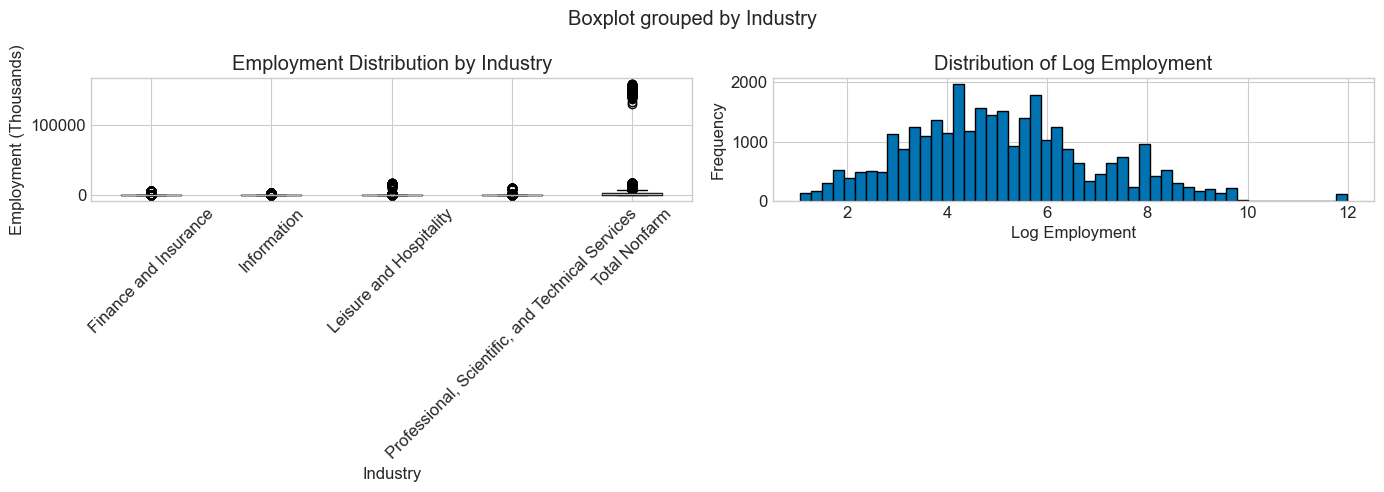

In [24]:
# Check for outliers in employment
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot by industry
df.boxplot(column='Employment', by='Industry', ax=axes[0], rot=45)
axes[0].set_title('Employment Distribution by Industry')
axes[0].set_xlabel('Industry')
axes[0].set_ylabel('Employment (Thousands)')

# Log employment distribution
df['LogEmployment'].hist(bins=50, ax=axes[1], edgecolor='black')
axes[1].set_xlabel('Log Employment')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Log Employment')

plt.tight_layout()
plt.show()

## 10. Key Takeaways for Regression Analysis

In [25]:
print("="*70)
print("KEY TAKEAWAYS FOR REGRESSION ANALYSIS")
print("="*70)

print("""
1. PARALLEL TRENDS:
   - Pre-treatment trends appear reasonably parallel, with COVID-19 as a 
     notable deviation in 2020.
   - Consider robustness checks excluding 2020 or using event study design.

2. TREATMENT CLASSIFICATION:
   - High Exposure: Information, Finance & Insurance, Prof/Sci/Tech Services
   - Low Exposure (Control): Leisure & Hospitality
   - Benchmark: Total Nonfarm (excluded from main analysis)

3. SAMPLE SIZE:
   - 31,152 total observations
   - 52 geographic units (states + DC + national)
   - 5 industries
   - 129 months (Jan 2015 - Sep 2025)

4. FIXED EFFECTS STRATEGY:
   - Industry FE: Absorbs AI exposure, teleworkability, RTI, skill intensity
   - Time FE: Absorbs economy-wide shocks (COVID, macro conditions)
   - State FE: Absorbs state-specific characteristics

5. POTENTIAL CONCERNS:
   - COVID-19 differential impact (especially on Leisure & Hospitality)
   - Anticipation effects (AI discussed before Nov 2022)
   - Spillover effects between industries
   - State-level heterogeneity in tech adoption

6. RECOMMENDED SPECIFICATIONS:
   a) Basic DiD: log(Emp) ~ Treat + Industry FE + Time FE
   b) With State FE: log(Emp) ~ Treat + Industry FE + Time FE + State FE
   c) Continuous treatment: log(Emp) ~ AI_Score*Post + FEs
   d) Event study: Include leads and lags of treatment
""")

KEY TAKEAWAYS FOR REGRESSION ANALYSIS

1. PARALLEL TRENDS:
   - Pre-treatment trends appear reasonably parallel, with COVID-19 as a 
     notable deviation in 2020.
   - Consider robustness checks excluding 2020 or using event study design.

2. TREATMENT CLASSIFICATION:
   - High Exposure: Information, Finance & Insurance, Prof/Sci/Tech Services
   - Low Exposure (Control): Leisure & Hospitality
   - Benchmark: Total Nonfarm (excluded from main analysis)

3. SAMPLE SIZE:
   - 31,152 total observations
   - 52 geographic units (states + DC + national)
   - 5 industries
   - 129 months (Jan 2015 - Sep 2025)

4. FIXED EFFECTS STRATEGY:
   - Industry FE: Absorbs AI exposure, teleworkability, RTI, skill intensity
   - Time FE: Absorbs economy-wide shocks (COVID, macro conditions)
   - State FE: Absorbs state-specific characteristics

5. POTENTIAL CONCERNS:
   - COVID-19 differential impact (especially on Leisure & Hospitality)
   - Anticipation effects (AI discussed before Nov 2022)
   - Sp

In [26]:
# Save summary statistics for reference
summary_stats = {
    'Total Observations': len(df),
    'States': df['State'].nunique(),
    'Industries': df['Industry'].nunique(),
    'Time Period': f"{df['Date'].min().date()} to {df['Date'].max().date()}",
    'Pre-period Obs': (df['Post'] == 0).sum(),
    'Post-period Obs': (df['Post'] == 1).sum(),
    'Treated Obs': (df['Treat'] == 1).sum(),
    'Simple DiD Estimate': round(did_estimate, 2)
}

pd.DataFrame([summary_stats]).T.to_csv('../data/summary_statistics.csv', header=['Value'])
print("Summary statistics saved to ../data/summary_statistics.csv")

Summary statistics saved to ../data/summary_statistics.csv
